# RNN Sentiment Classifier


In this notebook, we use an RNN to classify IMDB movie reviews by their sentiment.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NSC-BS-CS/CSB410_Labs/blob/main/BookLabs/8-rnn_sentiment_classifier.ipynb)


#### Load dependencies


In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import SimpleRNN # new!
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

#### Set hyperparameters


In [2]:
# output directory name:
output_dir = 'model_output/rnn'

# training:
epochs = 16 # way more!
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 10000
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# RNN layer architecture:
n_rnn = 256
drop_rnn = 0.2

# dense layer architecture:
# n_dense = 256
# dropout = 0.2

#### Load data


In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Preprocess data


In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture


In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in NLP like in
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Configure model


In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!


In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.5080 - loss: 0.7089 - val_accuracy: 0.5009 - val_loss: 0.7174
Epoch 2/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5365 - loss: 0.6894 - val_accuracy: 0.5800 - val_loss: 0.6688
Epoch 3/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6291 - loss: 0.6462 - val_accuracy: 0.5879 - val_loss: 0.6574
Epoch 4/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6829 - loss: 0.5880 - val_accuracy: 0.7549 - val_loss: 0.5302
Epoch 5/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7309 - loss: 0.5347 - val_accuracy: 0.6232 - val_loss: 0.6324
Epoch 6/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7201 - loss: 0.5589 - val_accuracy: 0.7800 - val_loss: 0.4935
Epoch 7/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8199 - loss: 0.4144 - val_accuracy: 0.7892 - val_loss: 0.4792
Epoch 8/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8379 - loss: 0.3801 - val_acc

#### Evaluate


In [12]:
model.load_weights(output_dir+"/weights.07.keras")

In [13]:
y_hat = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


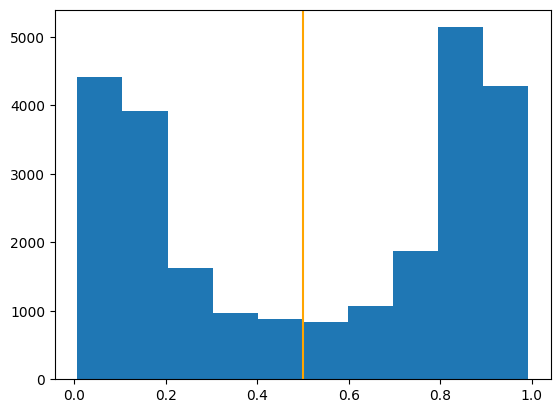

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'85.64'